In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import style
from itertools import cycle
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.preprocessing import Normalizer

from raman_lib.preprocessing import (BaselineCorrector,
                                     RangeLimiter,
                                     SavGolFilter)
from raman_lib.crossvalidation import CrossValidator
from raman_lib.visualization import (plot_validation_curve,
                                     plot_confidence_scores,
                                     plot_coefs,
                                     plot_confusion_matrix,
                                     plot_roc_curve,
                                     boxplot_comparison,
                                     plot_roc_comparison)

from raman_lib.misc import load_data

style.use("default")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

/home/daniel/raman-pca/raman_lib/crossvalidation.py:161: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Setup
### For storing results (when analyzing multiple datasets, only run this for the first one!)

In [2]:
accs = {}
fit_times = {}
predict_times = {}
p_vals = {}
rocs = {}
aucs = {}

### Settings

In [3]:
# Path where the data is stored
data_path = "./data/sersitive daten/"
name = "SERSitive Silver S"

# Spectral range to analyze
# Use 'None' to use the whole range'
wn_min = 450
wn_max = 1800

# Window size for smoothing the spectra
# Higher means stronger smoothing
sg_window = 15

n_trials = 20  # Randomized repetitions
n_folds = 5  # Cross validations

## Load Data

In [4]:
data = load_data(data_path)

if "file" in data.columns:
    X = data.drop(columns=["label", "file"])
else:
    X = data.drop(columns=["label"])
wns = np.asarray(X.columns.astype(float))
X = np.asarray(X)

y = np.asarray(data.label)
y, y_key = pd.factorize(y)

for i, label in enumerate(y_key):
    print(f"{label}: {i}")

nicht induziert: 0
induziert 2: 1


## Preprocessing

In [5]:
X_orig = X.copy()
X = BaselineCorrector().fit_transform(X)

rl = RangeLimiter(lim=(wn_min, wn_max), reference=wns)
X = rl.fit_transform(X)
wns_reduced = wns[rl.lim_[0]:rl.lim_[1]]

X = SavGolFilter().fit_transform(X)

X = Normalizer().fit_transform(X)

In [6]:
clf = Pipeline(steps=[("pca", PCA()),
                      ("lda", LinearDiscriminantAnalysis())])

p_grid = {
    "pca__n_components": range(1, 10)
}

scoring = [
    "accuracy"
]

cv = CrossValidator(clf, p_grid, 
                    coef_func=lambda x: np.matmul(x[0].components_.T,
                                                  x[1].scalings_),
                    n_jobs=-1,
                    feature_names=wns_reduced).fit(X, y)


  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
ct_df = pd.DataFrame(cv.ct_results_)

accs[name] = ct_df.test_score
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_score,test_score,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.992855,0.986011,0.254129,0.001080,6.580161e-14
std,0.002954,0.004066,0.009742,0.000423,5.269540e-14
min,0.988092,0.979540,0.226683,0.000395,2.440344e-14
25%,0.991478,0.986207,0.250628,0.000771,4.052771e-14
50%,0.993184,0.986207,0.251862,0.001037,4.052771e-14
75%,0.994890,0.986437,0.257221,0.001537,5.517306e-14
max,1.000000,0.993103,0.275477,0.001667,1.643451e-13


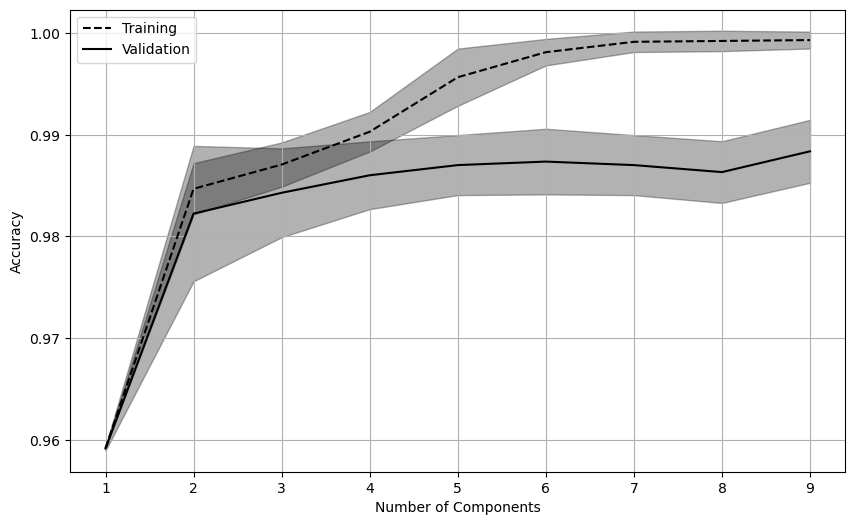

In [8]:
cv_df = pd.DataFrame(cv.cv_results_)

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xlabel("Number of Components")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

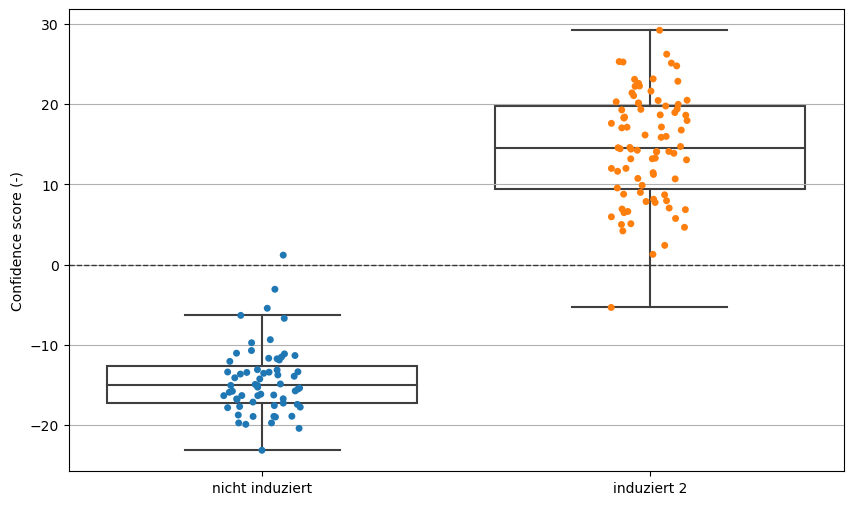

In [9]:
plot_probability = False

fig, ax = plt.subplots()
if plot_probability:
    conf_scores = cv.predictions_["probability"]
    ax.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
    ax.set_yscale("logit")
    ax.set_ylabel("Probability (-)")
else:
    conf_scores = cv.predictions_["conf_scores"]
    ax.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
    ax.set_ylabel("Confidence score (-)")

plot_confidence_scores(conf_scores, y_key[y], y_key, ax=ax)
ax.grid(axis="y")
ax.get_legend().remove()

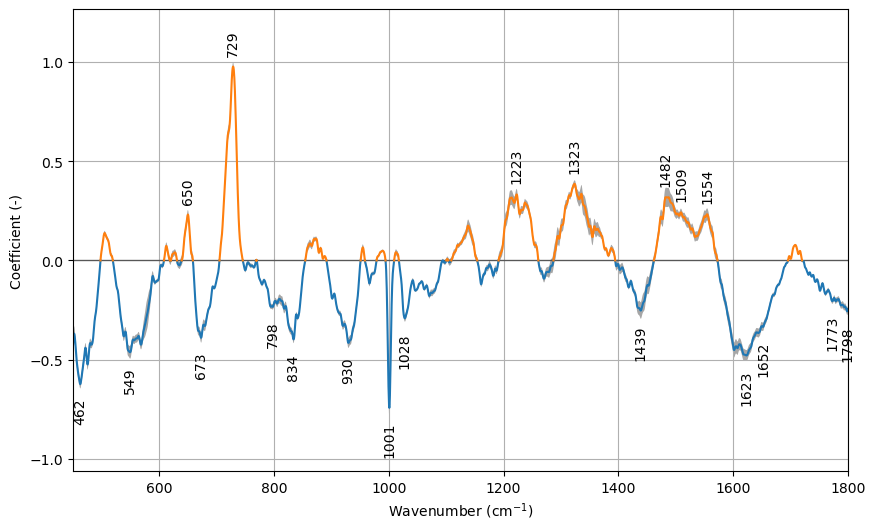

In [10]:
coef_df = pd.DataFrame(cv.coefs_, columns=wns_reduced)

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax, show_range=True, annotate=True, annot_kw={"min_height": 0.2, 
                                                                     "min_dist": 50,
                                                                     "offset": 10})

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)
ax.grid()

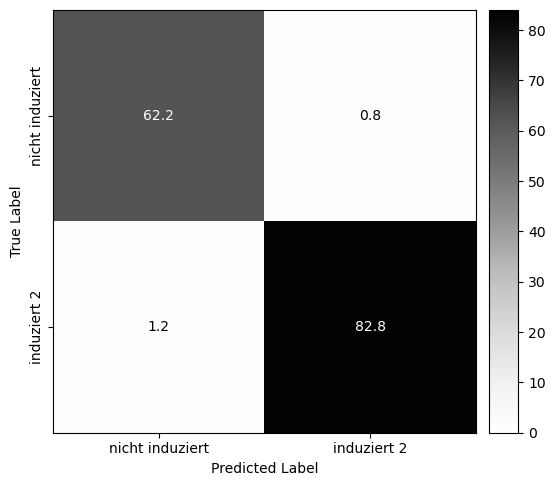

In [11]:
predictions = cv.predictions_["y_pred"]

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(predictions, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

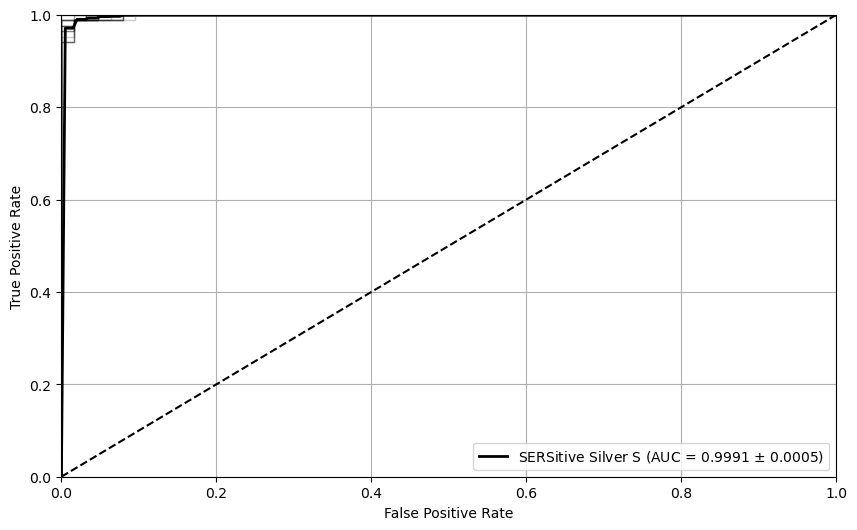

In [12]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(conf_scores, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

## Comparison

Text(0, 0.5, 'Accuracy')

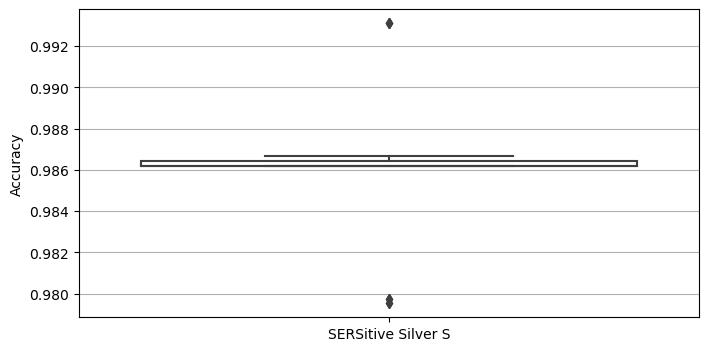

In [13]:
fig, ax = plt.subplots(figsize=(8,4))
boxplot_comparison(accs)

ax.grid(axis="y")
ax.set_ylabel("Accuracy")

Text(0, 0.5, 'p-Value')

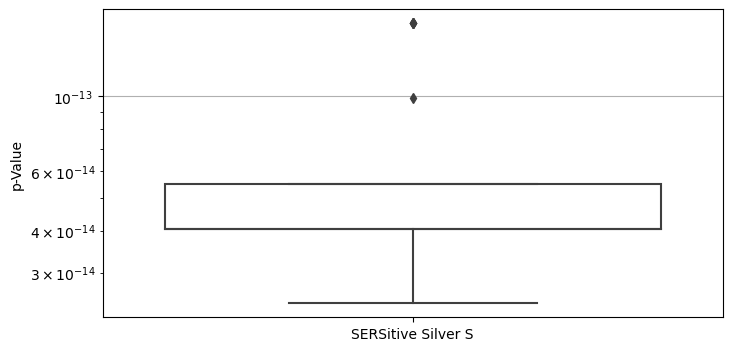

In [14]:
fig, ax = plt.subplots(figsize=(8,4))
boxplot_comparison(p_vals)

ax.set_yscale("log")
ax.grid(axis="y")
ax.set_ylabel("p-Value")

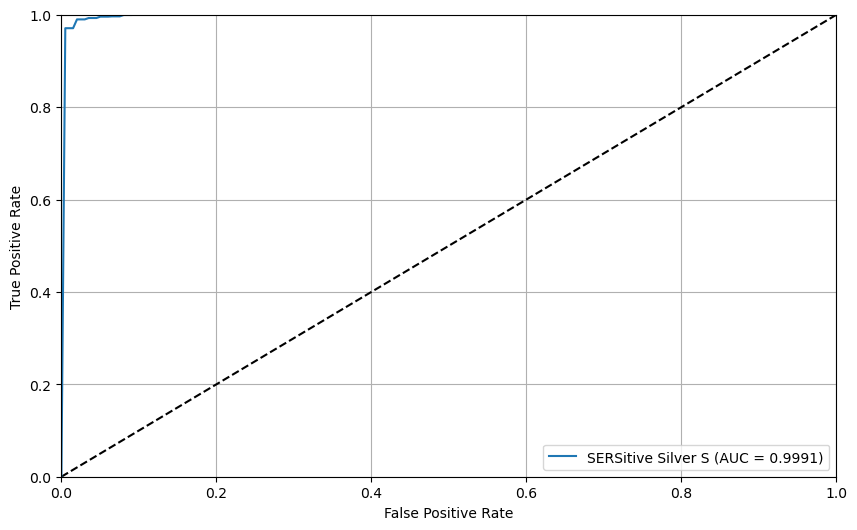

In [15]:
fig, ax = plt.subplots()
plot_roc_comparison(rocs, aucs, ax=ax)

ax.grid()
ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")